# Overview
This is my attempt to solve the 3rd assignment on the Signal Processing Course offered by Innopolis University

# Importing Data and first packages

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('first.csv', header=None) # do not read the first
# rename the columns
data.shape
# let's get rid of the last 12 samples
data = data.iloc[:, :-12]

In [3]:
## the MNE package
try:
    import mne
except ModuleNotFoundError:    
    ! pip install mne[hdf5]

In [4]:
try:
    import autoreject
except ModuleNotFoundError:
    ! pip install autoreject


# Preprocessing

Preprocessing EEG signals is crucial as the signal to noise ratio is not always high for several reasons:
1. Psychological: The human subject might have natural uncontrollable reflexes. The latter might generate signals interfering with the main ones.
2. Non-psychological: also referred to as ***artifacts***: mainly summarized in the interference of the equipements in the signals.

Using Fourier Transforms we can map the series from the time domain to the frequency domain. Generally the different types of noises are reflected through their frequencies.
1. Low frequency noises are generally for psychological reasons
2. High Frequency noises are gnerally for artificats 

So for filtering: use $0.1$ Hz as high pass and somewhere between $30$ Hz and $50$ Hz as low pass.

first 5 seconds are not informative cauase they are part of the expericment...    
the channbels in the rront are eyes...  
groupiung certain channels by activity     
after filtering the cahnnels, plot only for the low frequencies...

## Filtering and setting the channels correctly

In [5]:
import mne
mne.set_log_level('error')  # reduce extraneous MNE output

In [6]:
CHANNEL_NAMES = ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3']

In [7]:
# let's do this shit
import mne
import numpy as np

# let's convert the data to numpy
data_np = data.values

# assigning the channel type when initializing the Info object

ch_names = CHANNEL_NAMES

ch_types = ['eeg'] * 32

sampling_rate = 1000  # in Hertz

info = mne.create_info(ch_names= ch_names, ch_types= ch_types, sfreq= sampling_rate)

mne_data = mne.io.RawArray(data_np, info)


In [8]:
# let's set the montage first
montage = mne.channels.make_standard_montage('standard_1020')
mne_data.set_montage(montage, match_alias=True)

<RawArray | 32 x 10000 (10.0 s), ~2.5 MB, data loaded>

In [9]:
# let's filter the data first
ica_low_pass = 0.5
high_pass = 30
mne_data = mne_data.copy().filter(ica_low_pass, high_pass, picks='all')

c:\Users\bouab\DEV\ds_env\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


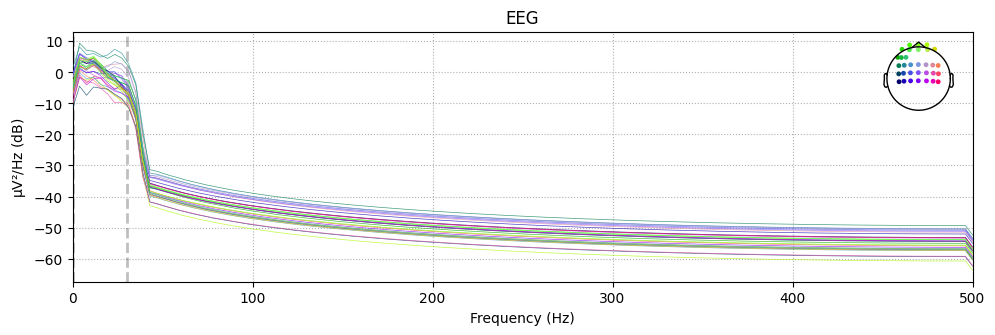

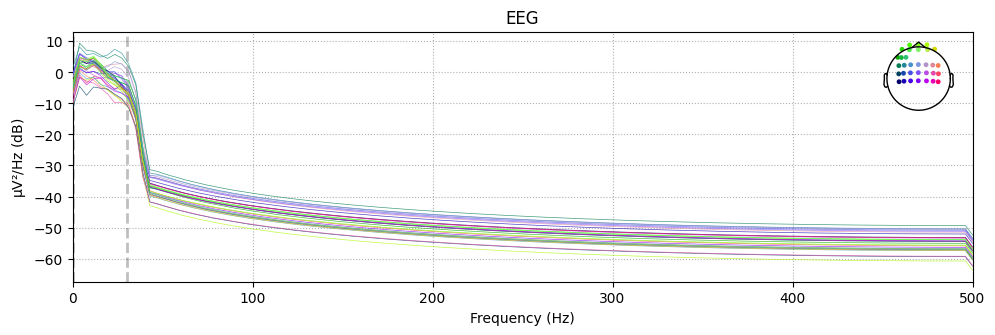

In [10]:
mne_data.compute_psd().plot()

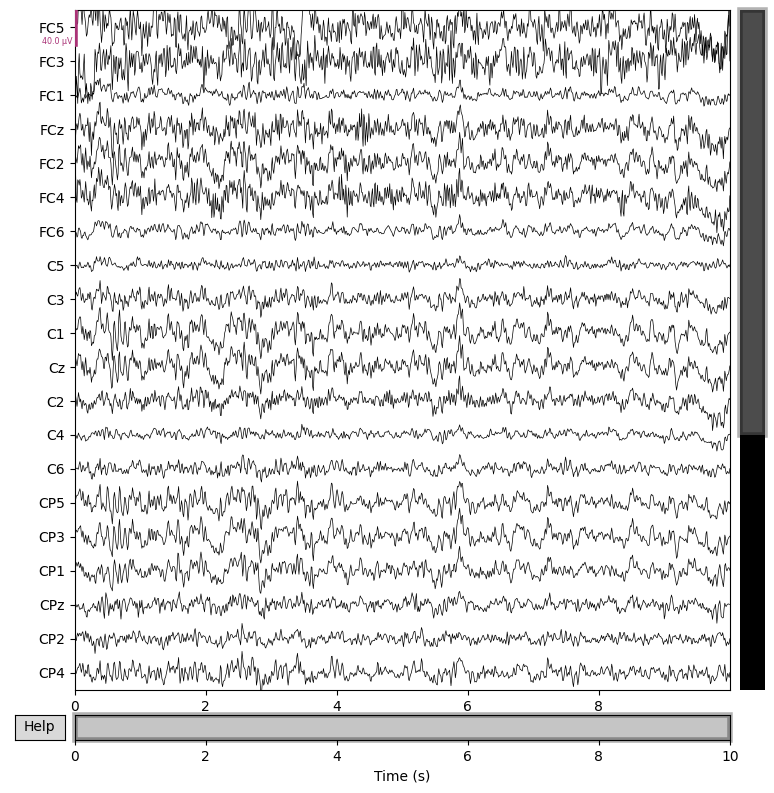

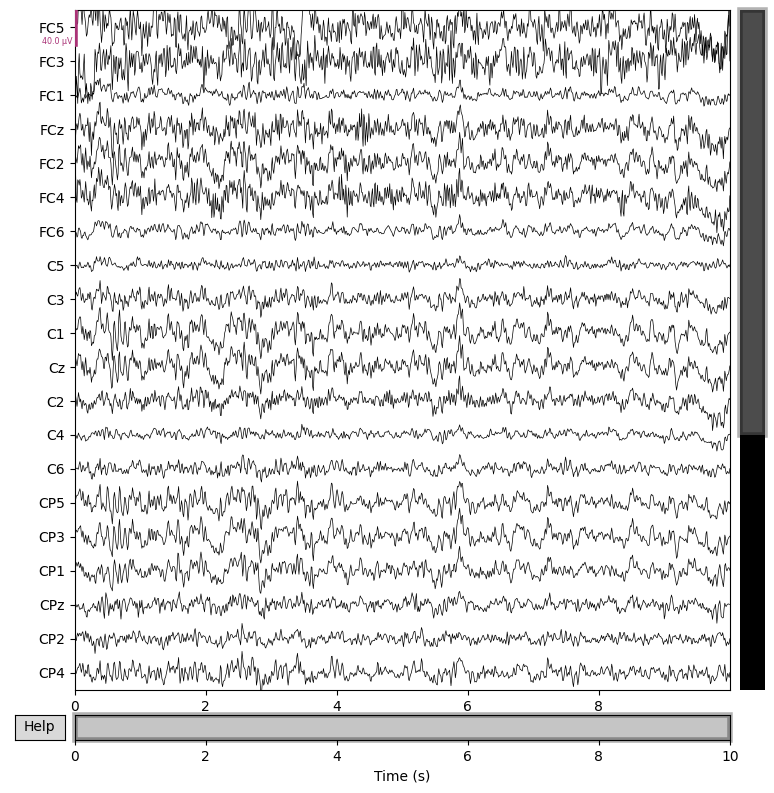

In [11]:
mne_data.plot()

In [12]:
# data_psd = mne_data.compute_psd()
# mne_data.plot_sensors()
# data_psd.plot_topomap()
# data_psd.plot()
# data.plot()

## Applying Independent Components Analysis

In [13]:
ica_low_cut = 1.0       # For ICA, we filter out more low-frequency power
hi_cut  = 30
ica_data = mne_data.copy().filter(ica_low_cut, hi_cut, picks='all')

In [14]:
tstep = 0.5
events_ica = mne.make_fixed_length_events(ica_data, duration=tstep)

picks = mne.pick_types(mne_data.info, meg=True, eeg=True, stim=False,
                       eog=True,misc=False, exclude='bads')

epochs_ica = mne.Epochs(ica_data, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

In [15]:
from autoreject import get_rejection_threshold
reject = get_rejection_threshold(epochs_ica)
print(reject)

Estimating rejection dictionary for eeg
{'eeg': 9.751342864530813e-05}


In [16]:
# ICA parameters
random_state = 42   # ensures ICA is reproducable each time it's run
ica_n_components = .95     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica,
        reject=reject,
        tstep=tstep)

c:\Users\bouab\DEV\ds_env\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Method,fastica
Fit,1000 iterations on epochs (9519 samples)
ICA components,8
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


In [17]:
# save the ica object for later use
ica.save('data-ica.fif', overwrite=True)

Method,fastica
Fit,1000 iterations on epochs (9519 samples)
ICA components,8
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


## Reducing the noise using ICA

In [18]:
tstep = 0.5
events = mne.make_fixed_length_events(mne_data, duration=tstep)

picks = mne.pick_types(mne_data.info, meg=True, eeg=True, stim=False,
                       eog=True,misc=False, exclude='bads')
epochs = mne.Epochs(mne_data, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

In [19]:
epochs

Number of events,19
Events,1: 19
Time range,0.000 – 0.500 sec
Baseline,off


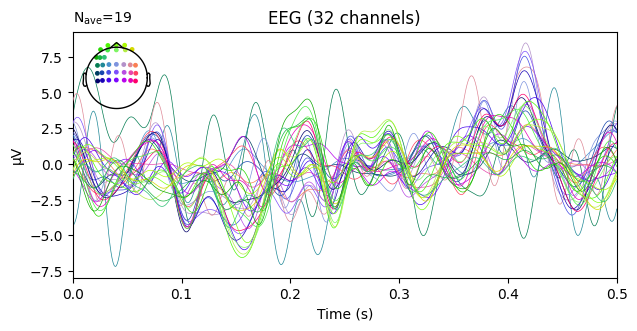

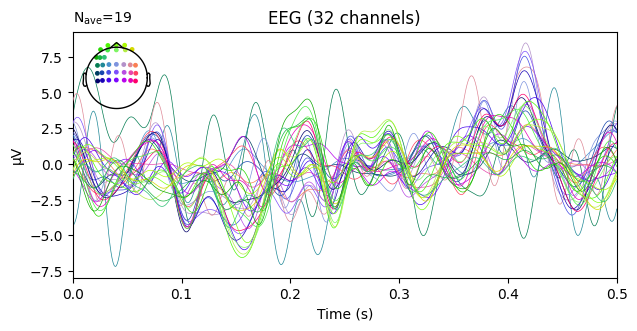

In [20]:
epochs.average().plot(spatial_colors=True)

In [21]:
# read the Independent component analysis
ica = mne.preprocessing.read_ica('data-ica.fif')
epochs_postica = ica.apply(epochs.copy())

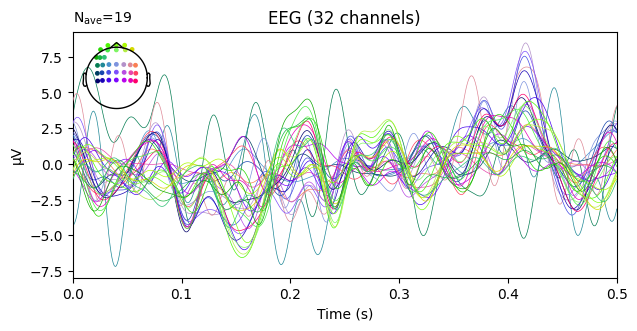

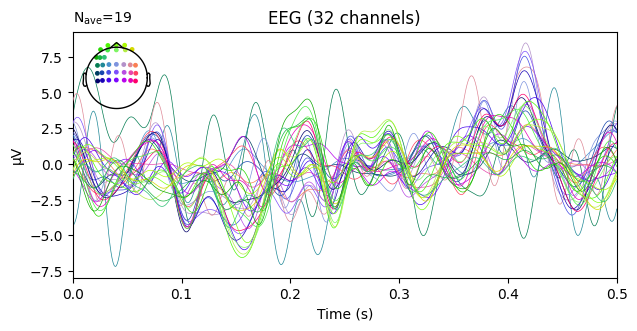

In [22]:
epochs_postica.average().plot(spatial_colors=True)